# About this notebook

Using multi-task learning to capture signals simultaneously from the fovea efficiently and the neighboring targets in the peripheral vision generate a visual response map. A calibration-free user-independent solution, desirable for clinical diagnostics. A stepping stone for an objective assessment of glaucoma patients’ visual field. [Read more...](https://jinglescode.github.io/ssvep-multi-task-learning/)

We can use this model as a classifier as well as a multi-label model.

If you use the model in your research or found this repo helpful, please cite our paper, [Deep Multi-Task Learning for SSVEP Detection and Visual Response Mapping](https://ieeexplore.ieee.org/abstract/document/9283310/):

```
@inproceedings{khok2020deep,
  title={Deep Multi-Task Learning for SSVEP Detection and Visual Response Mapping},
  author={Khok, Hong Jing and Koh, Victor Teck Chang and Guan, Cuntai},
  booktitle={2020 IEEE International Conference on Systems, Man, and Cybernetics (SMC)},
  pages={1280--1285},
  year={2020},
  organization={IEEE}
}
```

In [ ]:
%cd ../../../

In [2]:
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold

from bcikit.transforms.segment_time import segment_data_time_domain
from bcikit.datasets.ssvep import HSSSVEP
from bcikit.datasets import EEGDataloader
from bcikit.datasets import EEGDataset
from bcikit.datasets.data_selection_methods import leave_one_subject_out
from bcikit.models.utils import count_params
from bcikit.dataclass import BcikitConfig
from bcikit.models.MultitaskSSVEP.Trainer import Multitask_Trainer
from bcikit.models import MultitaskSSVEP

In [3]:
load_subject_id_range = (1, 35)
train_subject_ids = list(np.arange(load_subject_id_range[0], load_subject_id_range[1]+1, dtype=int))
print("Load subject IDs", train_subject_ids)
load_test_subject_id_range = (1, 35)
test_subject_ids = list(np.arange(load_test_subject_id_range[0], load_test_subject_id_range[1]+1, dtype=int))

config = {
    "seed": 12,
    "dataset": {
        "root": "../data/hsssvep",
        "num_channels": 9, # here we selected 9 channels as specified in the original dataset paper
        "num_classes": 40, 
        "subject_ids": train_subject_ids,  
        "sessions": None,  
        "do_recommended_preprocessing": True 
    },
    "optimizer": { 
        "weight_decay": 0.05,
    },
    "lr_scheduler": { 
        "learning_rate": 0.001,
        "patience": 5,
    },
    "criterion": { 
        
    },
    "model": { 
        "params": {
            "n1": 4,
            "kernel_window_ssvep": 59,
            "kernel_window": 19,
            "conv_3_dilation": 4,
            "conv_4_dilation": 4
        },
    },
    "training": { 
        "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
        "batchsize": 64,
        "kfold_split": 3,
        "num_epochs": 100,
        "early_stopping": 10,
    },
    "log_level": 1 
}

config = BcikitConfig(config)

torch.manual_seed(config.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
np.random.seed(config.seed)
torch.cuda.manual_seed(config.seed)

Load subject IDs [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]


# Data Loading and Preprocessing

In [ ]:
def preprocessing(data, targets, channel_names, sample_rate, segment_config, verbose, **kwargs):
    print()
    print("preprocessing data shape", data.shape) # (subject,session,trial,channel,time)

    # segment signal and select the first segment
    data = segment_data_time_domain(
        data=data,
        window_len=segment_config.window_len,
        shift_len=segment_config.shift_len,
        sample_rate=segment_config.sample_rate,
        add_segment_axis=True,
    )
    data = data[:, :, :, :, 0, :] # select the first segment, and remove the rest

    # since we are doing leave one subject out, we don't care about `session`, we only want data in this format (subject, trial, channel, time).
    data = data.reshape((data.shape[0], data.shape[1]*data.shape[2], data.shape[3], data.shape[4]))
    targets = targets.reshape((targets.shape[0], targets.shape[1]*targets.shape[2]))
    
    print("final data.shape", data.shape)
    print("final targets.shape", targets.shape)

    return data, targets

In [ ]:
def onehot_targets(targets, num_class=4):
    targets = targets.astype(np.long)
    onehot_y = np.zeros((targets.shape[0], num_class))
    onehot_y[np.arange(onehot_y.shape[0]), targets] = 1
    onehot_y = onehot_y.astype(np.long)
    return onehot_y


def leave_one_subject_out(self, test_subject_id=1, batchsize=32, kfold_k=0, kfold_split=3, **kwargs):
    """
    Since this is focus on subject, data should be preprocessed to (subject, trial, channel, time).
    This function select `test_subject_id` for test_loader, and creates `train_loader` and `val_loader` with stratified k-fold.
    """

    sub_idx = self.subject_ids.index(test_subject_id)

    # select test
    selected_subject_data = self.data[sub_idx, :, :, :]
    selected_subject_targets = self.targets[sub_idx, :]
    selected_subject_targets = onehot_targets(selected_subject_targets, num_class=config.dataset.num_classes)
    test_dataset = EEGDataset(selected_subject_data, selected_subject_targets)

    # select train and val
    indices = np.arange(self.data.shape[0])
    other_subjects_data = self.data[indices!=sub_idx, :, :, :]
    other_subjects_targets = self.targets[indices!=sub_idx, :]

    other_subjects_data = other_subjects_data.reshape((other_subjects_data.shape[0]*other_subjects_data.shape[1], other_subjects_data.shape[2], other_subjects_data.shape[3]))
    other_subjects_targets = other_subjects_targets.reshape((other_subjects_targets.shape[0]*other_subjects_targets.shape[1]))

    # k-fold cross validation
    (X_train, y_train), (X_val, y_val) = dataset_split_stratified(other_subjects_data, other_subjects_targets, k=kfold_k, n_splits=kfold_split, seed=71, shuffle=True, EEGDataset_class=None)
    
    y_train = onehot_targets(y_train, num_class=config.dataset.num_classes)
    y_val = onehot_targets(y_val, num_class=config.dataset.num_classes)

    train_dataset = EEGDataset(X_train, y_train)
    val_dataset = EEGDataset(X_val, y_val)

    # dataloader
    train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batchsize, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)
    
    return train_loader, val_loader, test_loader


def dataset_split_stratified(X, y, k=0, n_splits=3, seed=71, shuffle=True, EEGDataset_class=None):
    skf = StratifiedKFold(n_splits=n_splits, random_state=seed, shuffle=shuffle)
    split_data = skf.split(X, y)

    for idx, value in enumerate(split_data):

        if k != idx:
            continue
        else:
            train_index, test_index = value
        
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            return (X_train, y_train), (X_test, y_test)


In [4]:
segment_config = {
    "window_len": 1,
    "shift_len": 250,
    "sample_rate": 250,
}
segment_config = BcikitConfig(segment_config) 

data = EEGDataloader(
    dataset=HSSSVEP, 
    config=config,
    preprocessing_fn=preprocessing, 
    data_selection_fn=leave_one_subject_out,
    segment_config=segment_config, 
)

Load subject: 1
Load subject: 2
Load subject: 3
Load subject: 4
Load subject: 5
Load subject: 6
Load subject: 7
Load subject: 8
Load subject: 9
Load subject: 10
Load subject: 11
Load subject: 12
Load subject: 13
Load subject: 14
Load subject: 15
Load subject: 16
Load subject: 17
Load subject: 18
Load subject: 19
Load subject: 20
Load subject: 21
Load subject: 22
Load subject: 23
Load subject: 24
Load subject: 25
Load subject: 26
Load subject: 27
Load subject: 28
Load subject: 29
Load subject: 30
Load subject: 31
Load subject: 32
Load subject: 33
Load subject: 34
Load subject: 35

preprocessing data shape (35, 1, 240, 9, 1000)
final data.shape (35, 240, 9, 250)
final targets.shape (35, 240)


# Model and Training

In [7]:
model = MultitaskSSVEP(
    num_channel=config.dataset.num_channels,
    num_classes=config.dataset.num_classes,
    signal_length=segment_config.window_len * segment_config.sample_rate,
    filters_n1=config.model.params.n1,
    kernel_window_ssvep=config.model.params.kernel_window_ssvep,
    kernel_window=config.model.params.kernel_window,
    conv_3_dilation=config.model.params.conv_3_dilation,
    conv_4_dilation=config.model.params.conv_4_dilation,
)

x = torch.ones((40, config.dataset.num_channels, segment_config.window_len * segment_config.sample_rate))
print("Input shape:", x.shape)
y = model(x)
print("Output shape:", y.shape)

print('Model size:', count_params(model))

del model

Input shape: torch.Size([40, 9, 250])
Output shape: torch.Size([40, 40, 2])
Model size: 40756


In [9]:
subject_kfold_acc = {}
subject_kfold_f1 = {}

for subject_id in test_subject_ids:
    print('Subject', subject_id)
    kfold_acc = []
    kfold_f1 = []
        
    for k in range(config.training.kfold_split):
        train_loader, val_loader, test_loader = data.get_dataloaders(test_subject_id=subject_id, batchsize=config.training.batchsize, kfold_k=0, kfold_split=config.training.kfold_split)
        
        dataloaders_dict = {
            'train': train_loader,
            'val': val_loader
        }
        
        model = Multitask_Model(
            num_channel=config.dataset.num_channels,
            num_classes=config.dataset.num_classes,
            signal_length=segment_config.window_len * segment_config.sample_rate,
            filters_n1=config.model.params.n1,
            kernel_window_ssvep=config.model.params.kernel_window_ssvep,
            kernel_window=config.model.params.kernel_window,
            conv_3_dilation=config.model.params.conv_3_dilation,
            conv_4_dilation=config.model.params.conv_4_dilation,
        )

        epochs=config.training.num_epochs
        patience=config.lr_scheduler.patience
        early_stopping=config.training.early_stopping
        
        trainer = Multitask_Trainer(
            model, 
            model_name="model", 
            device=config.training.device, 
            learning_rate=config.lr_scheduler.learning_rate, 
            num_classes=config.dataset.num_classes, 
            multitask_learning=True, 
            patience=patience, 
            verbose=False, 
            print_training_metric=False, 
        )

        trainer.fit(dataloaders_dict, num_epochs=epochs, early_stopping=early_stopping, topk_accuracy=1, save_model=False)
        
        test_loss, test_acc, test_metric = trainer.validate(test_loader, 1)
        print('Testset (k={}) -> loss:{:.5f}, acc:{:.5f}, f1:{:.5f}'.format(k+1, test_loss, test_acc, test_metric))
        kfold_acc.append(test_acc)
        kfold_f1.append(test_metric)
    
    subject_kfold_acc[subject_id] = kfold_acc
    subject_kfold_f1[subject_id] = kfold_f1
    print()

print('Results')
print('subject_kfold_acc', subject_kfold_acc)
print('subject_kfold_f1', subject_kfold_f1)

Subject 1
Testset (k=1) -> loss:265.26735, acc:0.93800, f1:0.96800
Testset (k=2) -> loss:274.19940, acc:0.95800, f1:0.97900
Testset (k=3) -> loss:293.66931, acc:0.95400, f1:0.97700

Subject 2
Testset (k=1) -> loss:362.68385, acc:0.85400, f1:0.92100
Testset (k=2) -> loss:327.32542, acc:0.87500, f1:0.93300
Testset (k=3) -> loss:336.32041, acc:0.88300, f1:0.93800

Subject 3
Testset (k=1) -> loss:220.70792, acc:0.97500, f1:0.98700
Testset (k=2) -> loss:220.70792, acc:0.97500, f1:0.98700
Testset (k=3) -> loss:220.70792, acc:0.97500, f1:0.98700

Subject 4
Testset (k=1) -> loss:320.46512, acc:0.85400, f1:0.92100
Testset (k=2) -> loss:320.46512, acc:0.85400, f1:0.92100
Testset (k=3) -> loss:320.46512, acc:0.85400, f1:0.92100

Subject 5
Testset (k=1) -> loss:288.00494, acc:0.92100, f1:0.95900
Testset (k=2) -> loss:288.00494, acc:0.92100, f1:0.95900
Testset (k=3) -> loss:288.00494, acc:0.92100, f1:0.95900

Subject 6
Testset (k=1) -> loss:243.27907, acc:0.95000, f1:0.97400
Testset (k=2) -> loss:2

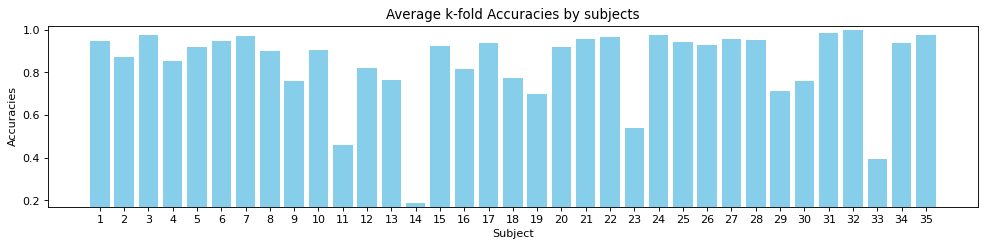

Average acc: 0.8386761904761905


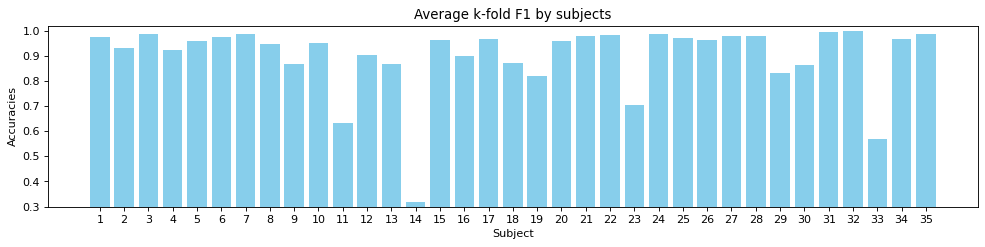

Average f1: 0.8982952380952381


In [10]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# acc
subjects = []
acc = []
acc_min = 1.0
acc_max = 0.0

for subject_id in subject_kfold_acc:
    subjects.append(subject_id)
    avg_acc = np.mean(subject_kfold_acc[subject_id])
    if avg_acc < acc_min:
        acc_min = avg_acc
    if avg_acc > acc_max:
        acc_max = avg_acc
    acc.append(avg_acc)


x_pos = [i for i, _ in enumerate(subjects)]
figure(num=None, figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')
plt.bar(x_pos, acc, color='skyblue')
plt.xlabel("Subject")
plt.ylabel("Accuracies")
plt.title("Average k-fold Accuracies by subjects")
plt.xticks(x_pos, subjects)
plt.ylim([acc_min-0.02, acc_max+0.02])
plt.show()

print('Average acc:', np.mean(acc))

# f1
subjects = []
f1 = []
f1_min = 1.0
f1_max = 0.0

for subject_id in subject_kfold_f1:
    subjects.append(subject_id)
    avg_f1 = np.mean(subject_kfold_f1[subject_id])
    if avg_f1 < f1_min:
        f1_min = avg_f1
    if avg_f1 > f1_max:
        f1_max = avg_f1
    f1.append(avg_f1)


x_pos = [i for i, _ in enumerate(subjects)]
figure(num=None, figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')
plt.bar(x_pos, f1, color='skyblue')
plt.xlabel("Subject")
plt.ylabel("Accuracies")
plt.title("Average k-fold F1 by subjects")
plt.xticks(x_pos, subjects)
plt.ylim([f1_min-0.02, f1_max+0.02])
plt.show()

print('Average f1:', np.mean(f1))